In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
from matplotlib import pyplot as plt

import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import log_loss
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier
from scipy.special import expit as sigmoid

from helpers import plot_losses

In [3]:
def run_logistic(A, y, param, logging=False):
    m = DecentralizedSGDLogistic(**param)
    list_losses = m.fit(A, y, logging=logging)
    if logging:
        print()
        print('{0} - score: {1:.4f}'.format(param, m.score(A, y)))
    return list_losses

In [4]:
def load_csv_data(data_path):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1

    return yb, input_data

In [5]:
def clean(input_data, mean=False):

    #Replace -999 by most frequent value of column
    for i in range(input_data.shape[1]):
        current_col = input_data[:, i]

        if -999.0 in current_col:
            indices_to_change = (current_col == -999.0)
            if mean:
                curr_mean = np.mean(current_col[~indices_to_change])
                current_col[indices_to_change] = curr_mean
            else:
                (values,counts) = np.unique(current_col[~indices_to_change], return_counts=True)
                ind=np.argmax(counts)
                current_col[indices_to_change] = values[ind] if len(values) > 0 else 0

    return input_data

In [6]:
def standardize(x):
    """Standardize the given data"""
    means = x.mean(0)
    stds = x.std(0)
    return (x - means)/stds

### Load Higgs Boson dataset

In [7]:
y, A = load_csv_data('train.csv')
A = standardize(clean(A, True))
y = 1 *(y > 0.0)

### Compute the baseline with SGD classifier 

In [8]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.745272
Final loss: 0.5070354539209662


### Computing with Decentralized SGD

In [9]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 30
params_disconnected = dict(num_epoch=25, lr_type='bottou',
                           initial_lr=0.05, tau=n_features, regularizer=reg,
                           quantization='full', n_machines=512,
                           method='plain', topology='disconnected', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive', 
                           compute_loss_every=compute_loss_every, tol=1e-10)

losses_disconnected = run_logistic(A, y, params_disconnected, logging=True)

length of indices: 512
length of last machine indices: 488
Epoch      Iteration      Time      Loss      Accuracy      
[1/25]     [488/488]      13s       0.6128    0.7097        
[2/25]     [488/488]      26s       0.5819    0.7211        
[3/25]     [488/488]      39s       0.5762    0.7250        
[4/25]     [488/488]      51s       0.5729    0.7272        
[5/25]     [488/488]      64s       0.5732    0.7278        
[6/25]     [488/488]      76s       0.5728    0.7290        
[7/25]     [488/488]      89s       0.5725    0.7299        
[8/25]     [488/488]      101s      0.5725    0.7290        
[9/25]     [488/488]      115s      0.5718    0.7295        
[10/25]    [488/488]      129s      0.5721    0.7298        
[11/25]    [488/488]      143s      0.5727    0.7303        
[12/25]    [488/488]      157s      0.5730    0.7308        
[13/25]    [488/488]      171s      0.5730    0.7303        
[14/25]    [488/488]      185s      0.5729    0.7307        
[15/25]    [488/488]      

In [10]:
params_complete = params_disconnected.copy()
params_complete['topology'] = 'complete'
losses_complete = run_logistic(A, y, params_complete, logging=True)

length of indices: 512
length of last machine indices: 488
Epoch      Iteration      Time      Loss      Accuracy      
[1/25]     [488/488]      14s       0.5991    0.7026        
[2/25]     [488/488]      28s       0.5742    0.7177        
[3/25]     [488/488]      42s       0.5684    0.7216        
[4/25]     [488/488]      55s       0.5663    0.7223        
[5/25]     [488/488]      69s       0.5650    0.7245        
[6/25]     [488/488]      83s       0.5643    0.7245        
[7/25]     [488/488]      96s       0.5640    0.7251        
[8/25]     [488/488]      110s      0.5637    0.7254        
[9/25]     [488/488]      124s      0.5635    0.7252        
[10/25]    [488/488]      137s      0.5636    0.7265        
[11/25]    [488/488]      151s      0.5633    0.7255        
[12/25]    [488/488]      165s      0.5632    0.7262        
[13/25]    [488/488]      178s      0.5631    0.7260        
[14/25]    [488/488]      192s      0.5631    0.7263        
[15/25]    [488/488]      

### Barbell and Path topologies

In [11]:
params_barbell = params_disconnected.copy()
params_barbell['topology'] = 'barbell'
losses_barbell = run_logistic(A, y, params_barbell, logging=True)

length of indices: 512
length of last machine indices: 488
Epoch      Iteration      Time      Loss      Accuracy      
[1/25]     [488/488]      14s       0.6578    0.6819        
[2/25]     [488/488]      28s       0.5889    0.7074        
[3/25]     [488/488]      42s       0.5738    0.7167        
[4/25]     [488/488]      56s       0.5686    0.7209        
[5/25]     [488/488]      70s       0.5665    0.7229        
[6/25]     [488/488]      83s       0.5652    0.7237        
[7/25]     [488/488]      97s       0.5645    0.7243        
[8/25]     [488/488]      111s      0.5641    0.7241        
[9/25]     [488/488]      124s      0.5637    0.7244        
[10/25]    [488/488]      138s      0.5635    0.7250        
[11/25]    [488/488]      152s      0.5633    0.7251        
[12/25]    [488/488]      165s      0.5633    0.7258        
[13/25]    [488/488]      179s      0.5632    0.7255        
[14/25]    [488/488]      193s      0.5630    0.7243        
[15/25]    [488/488]      

In [12]:
params_path = params_disconnected.copy()
params_path['topology'] = 'path'
losses_path = run_logistic(A, y, params_path, logging=True)

length of indices: 512
length of last machine indices: 488
Epoch      Iteration      Time      Loss      Accuracy      
[1/25]     [488/488]      14s       0.5993    0.7059        
[2/25]     [488/488]      28s       0.5773    0.7135        
[3/25]     [488/488]      42s       0.5701    0.7183        
[4/25]     [488/488]      56s       0.5671    0.7199        
[5/25]     [488/488]      69s       0.5654    0.7227        
[6/25]     [488/488]      83s       0.5646    0.7241        
[7/25]     [488/488]      97s       0.5644    0.7248        
[8/25]     [488/488]      110s      0.5639    0.7245        
[9/25]     [488/488]      124s      0.5635    0.7252        
[10/25]    [488/488]      139s      0.5632    0.7255        
[11/25]    [488/488]      153s      0.5631    0.7254        
[12/25]    [488/488]      166s      0.5631    0.7254        
[13/25]    [488/488]      180s      0.5631    0.7255        
[14/25]    [488/488]      194s      0.5630    0.7254        
[15/25]    [488/488]      

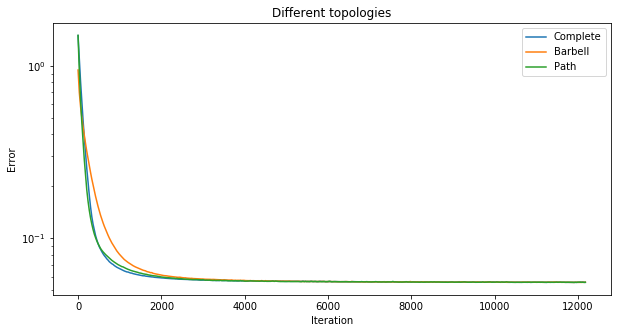

In [13]:
iterations_indices = np.arange(0, losses_complete.shape[0] * compute_loss_every, 
                               compute_loss_every)
plot_losses(np.stack((losses_complete, losses_barbell, losses_path)),
            iterations_indices, optimum_loss=optimum_loss, 
            labels=["Complete","Barbell", "Path"], title="Different topologies")

### Real Social Network Graph

In [14]:
import networkx as nx

In [15]:
G = nx.read_gml('power.gml', label=None)
G = G.to_undirected()
G.add_edge(0,0)

print("number of nodes " + str(G.number_of_nodes()))
print("number of edges " + str(G.number_of_edges()))

compute_loss_every_bigger = 10

number of nodes 4941
number of edges 6595


In [16]:
params_real = params_disconnected.copy()
params_real['topology'] = nx.adjacency_matrix(G).toarray()
params_real['compute_loss_every'] = compute_loss_every_bigger
params_real['n_machines'] = G.number_of_nodes()
losses_real = run_logistic(A, y, params_real, logging=True)

length of indices: 4999
length of last machine indices: 50
Epoch      Iteration      Time      Loss      Accuracy      
[1/25]     [50/50]        15s       1.1853    0.5800        
[2/25]     [50/50]        30s       0.9744    0.6250        
[3/25]     [50/50]        46s       0.8508    0.6564        
[4/25]     [50/50]        61s       0.7696    0.6780        
[5/25]     [50/50]        76s       0.7136    0.6937        
[6/25]     [50/50]        92s       0.6758    0.7038        
[7/25]     [50/50]        107s      0.6496    0.7114        
[8/25]     [50/50]        122s      0.6316    0.7165        
[9/25]     [50/50]        137s      0.6193    0.7202        
[10/25]    [50/50]        152s      0.6109    0.7232        
[11/25]    [50/50]        168s      0.6045    0.7251        
[12/25]    [50/50]        183s      0.5998    0.7267        
[13/25]    [50/50]        198s      0.5963    0.7276        
[14/25]    [50/50]        213s      0.5940    0.7283        
[15/25]    [50/50]        

In [17]:
# Takes time, but works
params_complete_bigger = params_disconnected.copy()
params_complete_bigger['topology'] = 'complete'
params_complete_bigger['compute_loss_every'] = compute_loss_every_bigger
params_complete_bigger['n_machines'] = G.number_of_nodes()
losses_complete_bigger = run_logistic(A, y, params_complete_bigger, logging=True)

length of indices: 4999
length of last machine indices: 50
Epoch      Iteration      Time      Loss      Accuracy      
[1/25]     [50/50]        15s       1.9625    0.4900        
[2/25]     [50/50]        31s       1.4275    0.5440        
[3/25]     [50/50]        46s       1.1530    0.5862        
[4/25]     [50/50]        61s       1.0003    0.6160        
[5/25]     [50/50]        76s       0.9047    0.6358        
[6/25]     [50/50]        91s       0.8373    0.6489        
[7/25]     [50/50]        107s      0.7861    0.6590        
[8/25]     [50/50]        122s      0.7460    0.6670        
[9/25]     [50/50]        138s      0.7142    0.6742        
[10/25]    [50/50]        153s      0.6889    0.6797        
[11/25]    [50/50]        168s      0.6687    0.6846        
[12/25]    [50/50]        183s      0.6529    0.6889        
[13/25]    [50/50]        199s      0.6401    0.6931        
[14/25]    [50/50]        214s      0.6297    0.6965        
[15/25]    [50/50]        

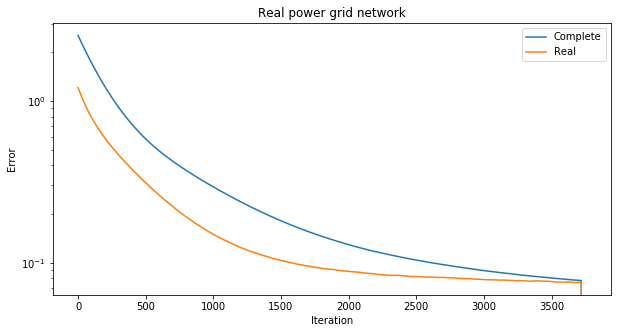

In [20]:
iterations_indices = np.arange(0, losses_real.shape[0] * compute_loss_every, 
                               compute_loss_every)
plot_losses(np.stack((losses_complete_bigger, losses_real)),
            iterations_indices, optimum_loss=optimum_loss, 
            labels=["Complete","Real"], title="Real power grid network")